The first three blcoks are utility functions provided for you and don not delete them!

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
%pip install autograd

In [6]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
from sklearn.linear_model import LinearRegression
import matplotlib.pylab as plt
import pandas as pd

In [7]:
###Utility Functions do not delete###
def generate_perturbed_X(X, delta, sampling, S, seed=0):
    np.random.seed(seed=seed)
    N = X.shape[0]
    D = X.shape[1]

    X_expanded = X[np.newaxis, :, :]
    if sampling == 'normal':
         epsilon_s = np.random.normal(0 , delta, size=(S, N, D))
         X_perturbed =  X_expanded + epsilon_s
    else:
        raise  Exception('Sampling {} not defined,'.format('sampling'))

    return X_perturbed

In [8]:
###Utility Functions do not delete###
def make_grid(lower, upper, num_points, num_dimensions):
    # Iterate over potential grid sizes
    for grid_size in range(2, num_points+1):
        total_points = grid_size ** num_dimensions
        if total_points >= num_points:
            break

    x = np.linspace(lower, upper, grid_size)
    arrs = np.meshgrid(*([x] * num_dimensions))
    grid = np.concatenate([x.flatten()[..., None] for x in arrs], axis=-1)

    # If the grid has more points than desired, truncate it
    if grid.shape[0] > num_points:
        grid = grid[:num_points]

    return grid

In [9]:
##Utility Functions do not delete##
def compute_gradient(fn, X):
  '''
  compute_gradient:
  input: fn, function to explain
       : X(N, D), input dataset
  output: gradient_set(N, D), the gradient of the function
  Note: we suggest you use elementwise_grad function from autograd library
  '''
  f_grad = elementwise_grad(fn)
  gradient_set = f_grad(X)
  return gradient_set

In [21]:
##Inputs and parameters to some of the utility functions are intialized for you.
N = 100
D = 2
sampling = "normal"
S = 1000
delta = 0.5
delta_list = np.linspace(0.000001, 3.0, 20)
X = make_grid(-5, 5, N, D)
assert X.shape == (N, D)
X_perturbed = generate_perturbed_X(X, delta, sampling, S)
assert X_perturbed.shape == (S, N, D)

In [11]:
###Define the functions you want to explain below, make sure that each function returns (N, ) shape object
def fn_cubed(X):
    X_arr = np.array(X)
    output = np.sum(X_arr ** 3, axis=1)
    return output

def fn_quadratic_quasi(X):
    X_arr = np.array(X)
    output = np.sum(np.sin(3 * X_arr) + (X_arr ** 2)/10, axis=1)
    return output

<h1>Question 1a: Smoothgrad implementation</h1>

For this question, you need to pass in X_perturbed (which is initialised for you above) instead of X to make a fair comparision between SmoothGrad and LIME

In [12]:
def compute_smoothgrad(X_perturbed, fn):
	'''
	compute_smoothgrad: computes smoothgrad explanations
	input: X_perturbed(S, N, D), the perturbed input is computed by another function called generate_X_perturbed()
		 : f, the function to explain
	output: W_sg(N,D), an explanation
	'''
	gradients = []

	for x in X_perturbed:
		gradients.append(compute_gradient(fn, x))

	return np.average(gradients, axis=0)

<h1>Question 1b: Lime implementation</h1>

In [13]:
def compute_Lime(X_perturbed: np.ndarray, fn):
	'''
	compute_Lime: computes lime explanations
	input: X_perturbed(S, N, D):  the perturbed input computed by generate_perturbed_input function
		 : f - the function to explain
	output: Explanations(N, D)
	'''
	outputs = []

	for x in X_perturbed:
		outputs.append(fn(x))

	outputs = np.array(outputs)
	dims = X_perturbed.shape
	explanations = []


	for x in range(dims[1]):
		Y = outputs[:,i]
		X = np.hstack([X_perturbed[:,x,:],
		               np.ones((dims[0],1))])
		results = np.linalg.lstsq(X, Y, rcond=None)[0]
		explanations.append(results[:-1])

	explanations = np.array(explanations)

	return explanations

<h1>Question 2: Visualization of distance to gradient</h1>
For this part, the visualization function is implemented for you, pass in the values.

In [14]:
def visualize_distance_from_the_gradient(X,delta_list, function1, function2, gradient_set_for_function1, gradient_set_for_function2):
    '''
    input:
          X(N, D): input dataset
          delta_list: a list of deltas
          function1, function2: functions to explain mentioned in question 2a and 2b
          gradient_set_for_function1(N, D), gradient_set_for_function2(N, D): gradient of the functions 1 and 2 respectively
    output:
          plots two graphs, one for  function 1 and one for function 2

    '''
    distance_from_sg_to_gradient_for_function1 = []
    distance_from_lime_to_gradient_for_function1 = []
    distance_from_sg_to_gradient_for_function2 = []
    distance_from_lime_to_gradient_for_function2 = []
    N = X.shape[0]

    print(f"Last delta is {delta_list[-1]}")
    for delta in delta_list:
        print(f"{delta = }")
        W_sg_for_function1 = compute_smoothgrad(generate_perturbed_X(X, delta, sampling, S, seed=0), function1)
        W_lime_for_function1 = compute_Lime(generate_perturbed_X(X, delta, sampling, S, seed=0), function1)
        W_sg_for_function2 = compute_smoothgrad(generate_perturbed_X(X, delta, sampling, S, seed=0), function2)
        W_lime_for_function2 = compute_Lime(generate_perturbed_X(X, delta, sampling, S, seed=0), function2)
        W_sg_quadratic_quasi = compute_smoothgrad(generate_perturbed_X(X, delta, sampling, S, seed=0), fn_quadratic_quasi)
        W_lime_quadratic_quasi = compute_Lime(generate_perturbed_X(X, delta, sampling, S, seed=0), fn_quadratic_quasi)
        distance_gradient_to_sg_function1 = (1/N) * np.power(np.linalg.norm(gradient_set_for_function1 - W_sg_for_function1), 2)
        distance_gradient_to_sg_function2 = (1/N) * np.power(np.linalg.norm(gradient_set_for_function2 - W_sg_for_function2), 2)
        distance_gradient_to_lime_function1 = (1/N) * np.power(np.linalg.norm(gradient_set_for_function1 - W_lime_for_function1), 2)
        distance_gradient_to_lime_function2 = (1/N) * np.power(np.linalg.norm(gradient_set_for_function2 - W_lime_for_function2), 2)
        distance_from_sg_to_gradient_for_function1.append(distance_gradient_to_sg_function1)
        distance_from_lime_to_gradient_for_function1.append(distance_gradient_to_lime_function1)
        distance_from_sg_to_gradient_for_function2.append(distance_gradient_to_sg_function2)
        distance_from_lime_to_gradient_for_function2.append(distance_gradient_to_lime_function2)
    # print(distance_from_lime_to_the_gradient)
    # Plot the distances
    fig, ax = plt.subplots(1,2, figsize=(10, 6))
    ax[0].plot(delta_list, distance_from_sg_to_gradient_for_function1, color='black', label='Smoothgrad')
    ax[0].plot(delta_list, distance_from_lime_to_gradient_for_function1, color='red', label='LIME')
    ax[1].plot(delta_list, distance_from_sg_to_gradient_for_function2, color='black', label='Smoothgrad')
    ax[1].plot(delta_list, distance_from_lime_to_gradient_for_function2, color='red', label='LIME')
    ax[1].set_xlabel('Deltas')
    ax[1].set_ylabel('Distance to the gradient')
    # ax[1].set_title('Distance from SmoothGrad and Lime to gradient over different deltas')
    ax[0].set_xlabel('Deltas')
    ax[0].set_ylabel('Distance to the gradient')
    # ax.set_title('Distance from SmoothGrad and Lime to gradient over different deltas')
    ax[0].set_title('fn_cubed')
    ax[1].set_title('fnn_quasi')
    ax[0].legend()
    ax[1].legend()
    plt.savefig('distance_from_sg_to_the_gradient_for_quadratic_quasi_function.png')
    plt.show()

In [15]:
# Compute gradients
cubed_gradient = compute_gradient(fn_cubed, X)
quadratic_quasi_gradient = compute_gradient(fn_quadratic_quasi, X)

Last delta is 3.0
delta = 1e-06
delta = 0.1578956842105263
delta = 0.31579036842105257
delta = 0.47368505263157884
delta = 0.6315797368421052
delta = 0.7894744210526315
delta = 0.9473691052631578
delta = 1.105263789473684
delta = 1.2631584736842103
delta = 1.4210531578947365
delta = 1.578947842105263
delta = 1.7368425263157892
delta = 1.8947372105263154
delta = 2.052631894736842
delta = 2.2105265789473685
delta = 2.3684212631578947
delta = 2.526315947368421
delta = 2.684210631578947
delta = 2.8421053157894733
delta = 3.0


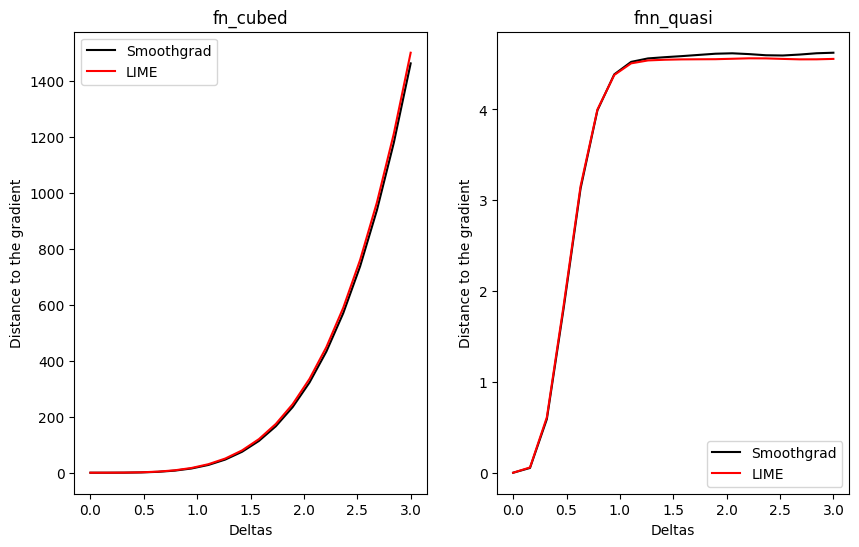

In [24]:
# Visualization
visualize_distance_from_the_gradient(X,
                                     delta_list,
                                     fn_cubed,
                                     fn_quadratic_quasi,
                                     cubed_gradient,
                                     quadratic_quasi_gradient)

<h1>Question 3a: Faithfulness and Robustness loss </h1>

In [28]:
def compute_faithfulness_loss(W_G, W_E):
	'''
	compute_faithfulness_loss : computes the loss for the faithfulness objective
	input : W_G(N, D), the gradient of the function to explain
		  : W_E(N,D), an explantion of the function using Smoothgrad and Lime
	output(): summation: A sum of the difference between the W_G and W_E
	'''
	losses = []
	for grad, expl in zip(W_G, W_E):
		losses.append(grad - expl)

	sum = 0
	for loss in losses:
		sum += np.dot(loss, loss)

	return sum

In [29]:
import itertools as i
def compute_robustness_loss(W_E):
	'''
	compute_robustness_loss:computes the loss for the robustness objective
	input : W_E(N, D): the explanation provided by Smoothgrad and Lime,
	output(): the sum of  the difference between pair of points n and n_prime (W_E_n  and W_E_n_prime)
	'''
	losses = []
	for expl, expl_prime in i.product(W_E, W_E):
		losses.append(expl - expl_prime)

	sum = 0
	for loss in losses:
		sum += np.dot(loss, loss)

	return sum

<h1>Question 3b: Visualization of Faithfulness and Robustness loss</h1>
This visualization function is implemented for you, pass in the values

In [30]:
def faithfulness_loss_visualization(
    delta_list,
    faithfulness_loss_sg_func1,
    faithfulness_loss_lime_func1,
    faithfulness_loss_sg_func2,
    faithfulness_loss_lime_func2
):
    """
    Visualizes the faithfulness loss of SmoothGrad and LIME for two functions.

    Parameters:
    - delta_list: List of delta values.
    - faithfulness_loss_sg_func1: a list of faithfulness loss values for function 1 explained by  SmoothGrad
    - faithfulness_loss_lime_func1: a list of faithfulness loss values for function 1 explained by  LIME
    - faithfulness_loss_sg_func2: a list of faithfulness loss values for function 2 explained by  SmoothGrad
    - faithfulness_loss_lime_func2: a list of faithfulness loss values for function 2 explained by  LIME

    Returns:
    - None:  displays a visualization of the faithfulness loss vs delta.
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax[0].plot(delta_list, faithfulness_loss_sg_func1, color='black', label='Smoothgrad')
    ax[0].plot(delta_list, faithfulness_loss_lime_func1, color='red', label='LIME')
    ax[1].set_xlabel('Delta')
    ax[0].set_ylabel('Faithfulness Loss')
    ax[0].set_title('Cubic Function')
    ax[1].set_title('Quasi  Function')
    ax[1].plot(delta_list, faithfulness_loss_sg_func2, color='black', label='Smoothgrad')
    ax[1].plot(delta_list, faithfulness_loss_lime_func2, color='red', label='LIME')
    ax[1].set_xlabel('Delta')
    ax[1].set_ylabel('Faithfulness Loss')
    ax[0].set_title('fn_cubed')
    ax[1].set_title('fnn_quasi')
    ax[0].legend()
    ax[1].legend()
    # plt.savefig('faithfulness_loss.png')
    plt.tight_layout()
    plt.show()

In [31]:
def robustness_loss_visualization(
    delta_list,
    robustness_loss_sg_func1,
    robustness_loss_lime_func1,
    robustness_loss_sg_func2,
    robustness_loss_lime_func2 ):
  fig, ax = plt.subplots(1, 2, figsize=(10, 6))
  ax[0].plot(delta_list, robustness_loss_sg_func1, color='black', label='Smoothgrad')
  ax[0].plot(delta_list, robustness_loss_lime_func1, color='red', label='LIME')
  ax[1].plot(delta_list, robustness_loss_sg_func2, color='black', label='Smoothgrad')
  ax[1].plot(delta_list, robustness_loss_lime_func2, color='red', label='LIME')
  ax[0].set_xlabel('Delta')
  ax[1].set_xlabel('Delta')
  ax[0].set_ylabel('Robustness Loss')
  ax[1].set_ylabel('Robustness Loss')
  ax[0].set_title('fn_cubed')
  ax[1].set_title('fnn_quasi')
  ax[0].legend()
  ax[1].legend()
  plt.savefig('robustness_loss_plot.png')
  plt.tight_layout()
  plt.show()


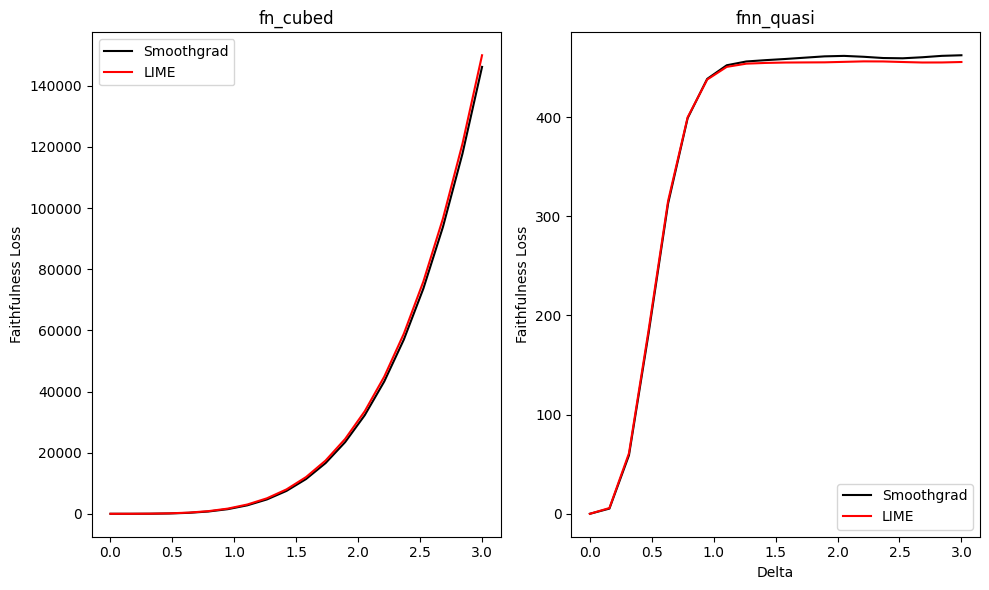

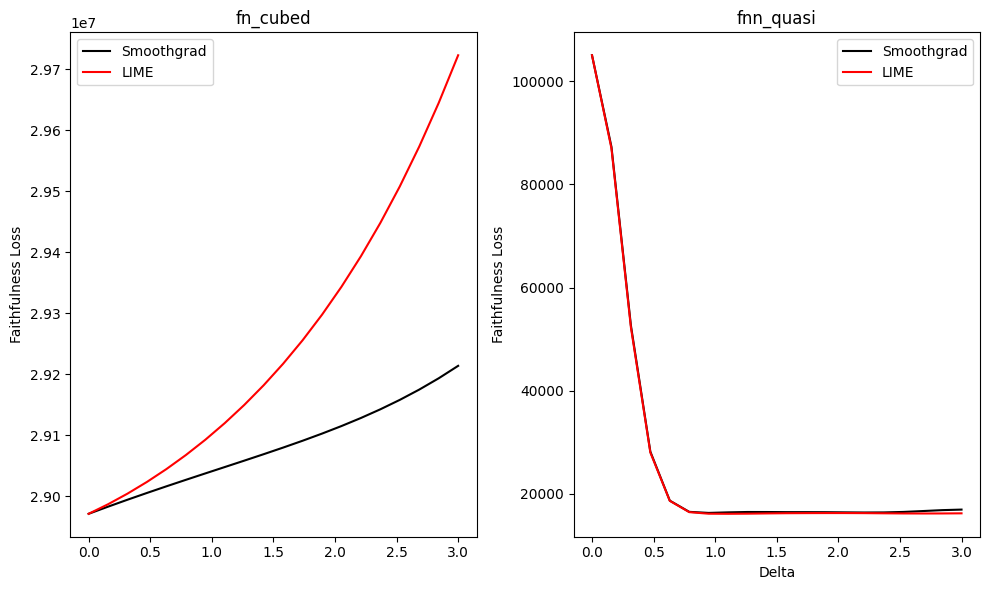

In [33]:
# Helper function for calculating losses
def compute_loss(X, fn, delta_list, loss_func_type, loss_func, expl_method):

  grads = compute_gradient(fn, X)
  explanations = []

  for delta in delta_list:
    X_perturbed = generate_perturbed_X(X, delta, sampling, S, seed=0)
    explanations.append(expl_method(X_perturbed, fn))

  losses = []

  for expl in explanations:
    if loss_func_type == "robustness":
      losses.append(loss_func(expl))
    else:

      losses.append(loss_func(grads, expl))

  return losses

faithfulness_loss_visualization(
    delta_list,
    compute_loss(X, fn_cubed, delta_list, 'faithfulness', compute_faithfulness_loss, compute_smoothgrad),
    compute_loss(X, fn_cubed, delta_list, 'faithfulness', compute_faithfulness_loss, compute_Lime),
    compute_loss(X, fn_quadratic_quasi, delta_list, 'faithfulness', compute_faithfulness_loss, compute_smoothgrad),
    compute_loss(X, fn_quadratic_quasi, delta_list, 'faithfulness', compute_faithfulness_loss, compute_Lime)
)

faithfulness_loss_visualization(
    delta_list,
    compute_loss(X, fn_cubed, delta_list, 'robustness', compute_robustness_loss, compute_smoothgrad),
    compute_loss(X, fn_cubed, delta_list, 'robustness', compute_robustness_loss, compute_Lime),
    compute_loss(X, fn_quadratic_quasi, delta_list, 'robustness', compute_robustness_loss, compute_smoothgrad),
    compute_loss(X, fn_quadratic_quasi, delta_list, 'robustness', compute_robustness_loss, compute_Lime)
)